In [1]:
# The gp_sfh.py file contains a simple GP framework that we'll be using
from gp_sfh import *
from gp_sfh_kernels import *

# also add dense basis for realistic SFHs
import dense_basis as db

#--------------------------------------------------------------------------------------
# import FSPS and set up a fiducial set of parameters (dust, metallicity, IMF, etc.)
#--------------------------------------------------------------------------------------

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

from copy import deepcopy
import hickle

import fsps
sp = fsps.StellarPopulation(imf_type=2, zcontinuous=1)
sp.params['imf_type'] = 1 # Chabrier
sp.params['logzsol'] = 0.0 # Solar metallicity
sp.params['dust_type'] = 2 # Calzetti
sp.params['dust2'] = 0.2
sp.params['sfh'] = 3
sp.params['add_neb_emission'] = True
sp.params['add_neb_continuum'] = True

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
import pandas as pd
import corner

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.


In [2]:
kernel_params_MW_1dex = [1.0, 2500/1e3, 150/1e3, 0.03, 25/1e3]
kernel_params_dwarf_1dex = [1.0, 30/1e3, 150/1e3, 0.03, 10/1e3]
kernel_params_noon_1dex = [1.0, 200/1e3, 100/1e3, 0.03, 50/1e3]
kernel_params_highz_1dex = [1.0, 15/1e3, 16/1e3, 0.03, 6/1e3]

TCF20_scattervals = [0.17, 0.53, 0.24, 0.27]
kernel_params_MW_TCF20 = [np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 2500/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[0]**2/(1 + (0.03)**2)), 25/1e3]
kernel_params_dwarf_TCF20 = [np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 30/1e3, 150/1e3, 0.03*np.sqrt(TCF20_scattervals[1]**2/(1 + (0.03)**2)), 10/1e3]
kernel_params_noon_TCF20 = [np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 200/1e3, 100/1e3, 0.03*np.sqrt(TCF20_scattervals[2]**2/(1 + (0.03)**2)), 50/1e3]
kernel_params_highz_TCF20 = [np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 15/1e3, 16/1e3, 0.03*np.sqrt(TCF20_scattervals[3]**2/(1 + (0.03)**2)), 6/1e3]

In [5]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_MW_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:05<00:00, 174.11it/s]


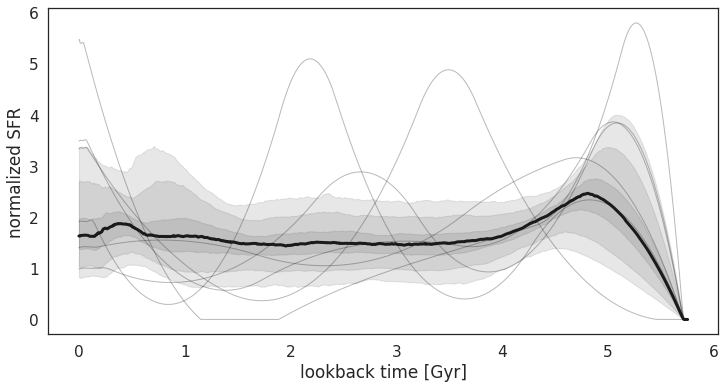

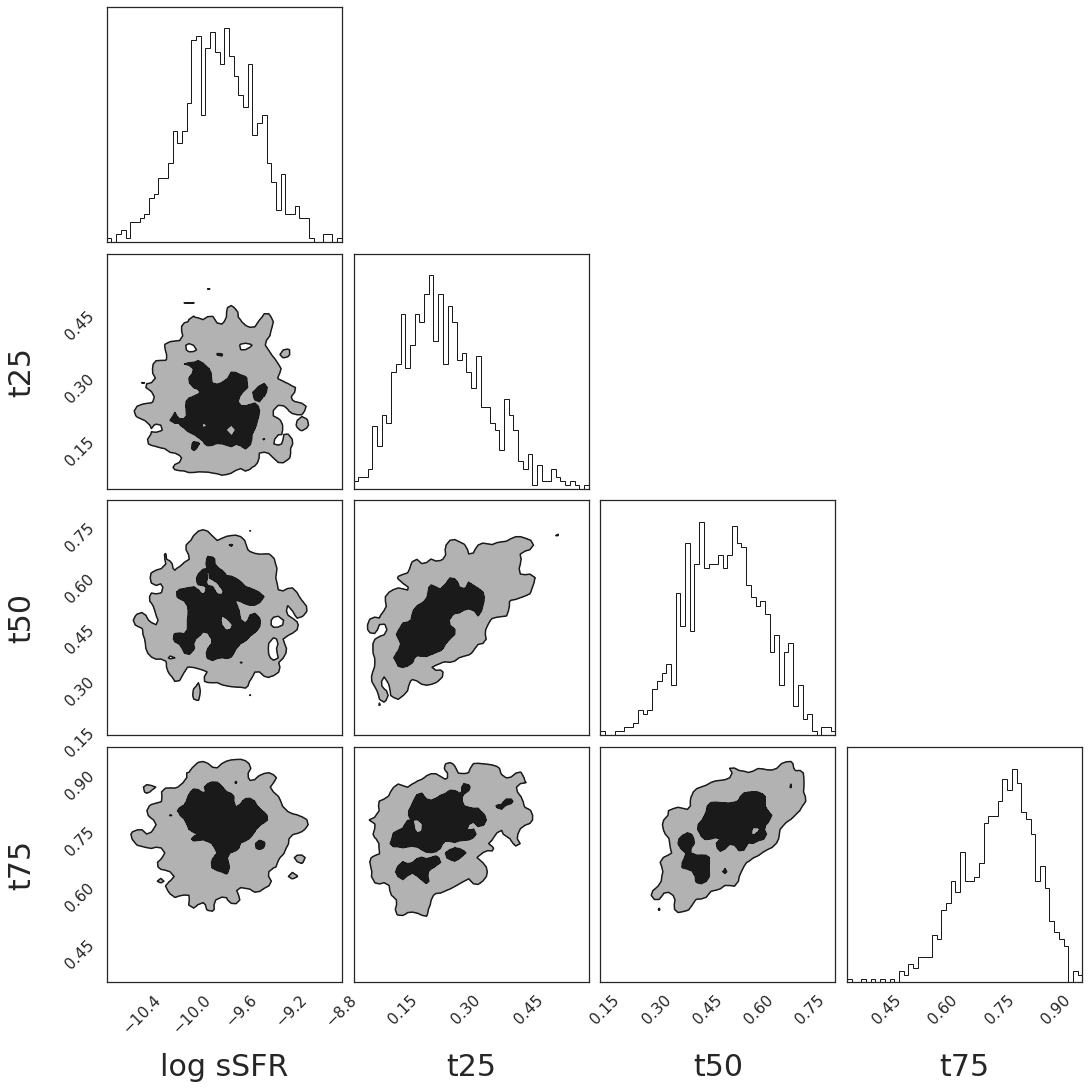

In [32]:
def normal_sfr():
    return np.random.normal(scale=0.3)-0.77

priors = db.Priors()
priors.Nparam = 3
#priors.sfr_prior_type = 'sSFRlognormal'
priors.sample_sfr_prior = normal_sfr
priors.mass_min = 9-1e-6
priors.mass_max = 9+1e-6
priors.sample_sfh_tuple()

#priors.plot_prior_distributions()

priors.plot_sfh_prior(numdraws=1000, zval=zval)

1000

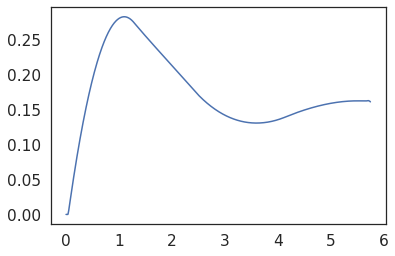

In [42]:
temp_sfh, temp_time = db.tuple_to_sfh(priors.sample_sfh_tuple(), zval=zval)
plt.plot(temp_time, temp_sfh)

In [64]:
def get_spec(self, nsamp):

    bands = fsps.list_filters()
    filter_wavelengths = [fsps.filters.get_filter(bands[i]).lambda_eff for i in range(len(bands))]

    all_lam, all_spec, all_spec_massnorm, all_mstar, all_emline_wav, all_emline_lum, all_emline_lum_massnorm, all_filtmags, all_basesfhs = [], [], [], [], [], [], [], [], []

    for i in tqdm(range(nsamp)):
        
        temp_sfh, temp_time = db.tuple_to_sfh(priors.sample_sfh_tuple(), zval=zval)
        log_tempsfh = np.log10(temp_sfh)
        log_tempsfh[np.isnan(log_tempsfh)] = -3
        specsfh = 10**(log_tempsfh+self.samples[i, 0:])
        #specsfh = 10**(self.basesfh+self.samples[i, 0:])
        self.sp.set_tabular_sfh(self.tarr, specsfh)
        lam, spec = self.sp.get_spectrum(tage = self.t_univ)
        mstar = self.sp.stellar_mass
        bandmags = self.sp.get_mags(tage = self.cosmo.age(self.zval).value, redshift = self.zval, bands = bands)

        all_lam.append(lam)
        all_spec.append(spec)
        all_spec_massnorm.append(spec/mstar)
        all_mstar.append(mstar)
        all_emline_wav.append(self.sp.emline_wavelengths)
        all_emline_lum.append(self.sp.emline_luminosity)
        all_emline_lum_massnorm.append(self.sp.emline_luminosity / mstar)
        all_filtmags.append(bandmags)
        all_basesfhs.append(log_tempsfh)

    self.lam = all_lam
    self.spec = all_spec
    self.spec_massnorm = all_spec_massnorm
    self.mstar = all_mstar
    self.emline_wav = all_emline_wav
    self.emline_lum = all_emline_lum
    self.emline_lum_massnorm = all_emline_lum_massnorm
    self.basesfhs = all_basesfhs

    # not mass normalized
    self.bands = bands
    self.filter_wavelengths = filter_wavelengths
    self.filtmags = all_filtmags

    return

In [65]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_MW_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist

case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

get_spec(case1, nsamp = nsamp)
case1.calc_spectral_features(massnorm = True)

hickle.dump(case1, 'precomputed_kernels/varsfh_MW.h5')

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:00<00:00, 13657.73it/s]


In [66]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_dwarf_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

get_spec(case1, nsamp = nsamp)
case1.calc_spectral_features(massnorm = True)

hickle.dump(case1, 'precomputed_kernels/varsfh_dwarf.h5')

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:00<00:00, 13213.07it/s]


In [76]:
nsamp = 1000
tarr_res = 1000
zval = 1.0
random_seed = 42

case_params = kernel_params_noon_TCF20

case1 = simple_GP_sfh(sp=sp, cosmo=cosmo, zval = zval)
case1.get_tarr(n_tarr = tarr_res)
#case1.get_basesfh(sfhtype='MS', mstar = 10.0)
case1.get_basesfh(sfhtype='dirichlet')
case1.kernel = extended_regulator_model_kernel_paramlist


case1.samples = case1.sample_kernel(nsamp = nsamp, random_seed = random_seed, 
                                    force_cov=True, kernel_params = case_params)

get_spec(case1, nsamp = nsamp)
case1.calc_spectral_features(massnorm = True)

hickle.dump(case1, 'precomputed_kernels/varsfh_noon.h5')

unknown basesfh type. set yourself with len of tarr.


100%|██████████| 1000/1000 [00:00<00:00, 13850.18it/s]


8.807114098288832
9.10309701937799
8.867578180220807


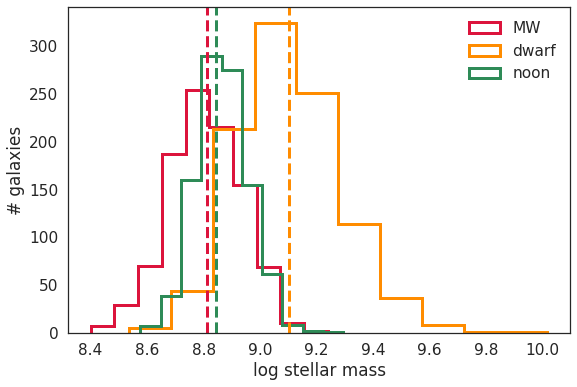

In [78]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/varsfh_'+case+'.h5'
    case1 = hickle.load(fname)
    plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
    
    print(np.mean(np.log10(case1.mstar)))
    plt.axvline(9.00 + np.log10(0.6) + np.pi/np.e*TCF20_scattervals[i]**2,lw=3,color=case_colors[i],linestyle='--')

plt.legend(edgecolor='w')
#plt.xscale('log');plt.yscale('log')
#plt.ylim(1e-3,1e1)
plt.xlabel('log stellar mass')
plt.ylabel('# galaxies')
#plt.savefig('figures/massdist_TCF20.png')
plt.show()
    

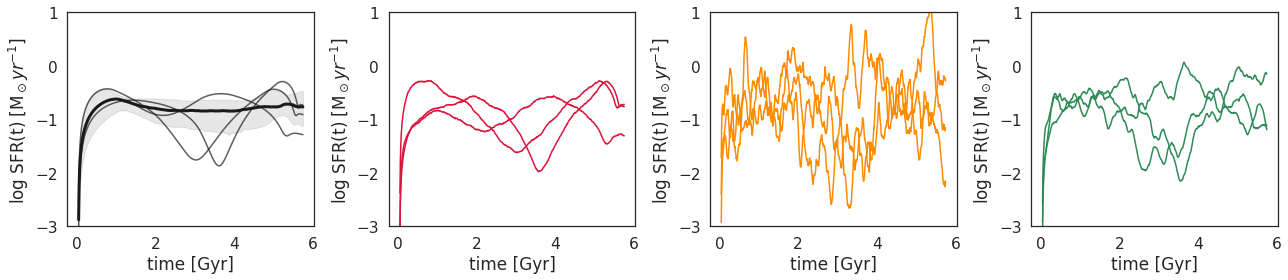

In [94]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(18,4))

plt.subplot(1,4,1)
plt.plot(case1.tarr, np.nanmedian(np.array(case1.basesfhs),0),'k-',lw=3)
plt.fill_between(case1.tarr, np.nanpercentile(np.array(case1.basesfhs),16,0),
                np.nanpercentile(np.array(case1.basesfhs),84,0),color='k',alpha=0.1)
for si in range(3):
    plt.plot(case1.tarr, case1.basesfhs[si], color='k',alpha=0.7)
plt.ylim(-3,1.0)
plt.xlabel('time [Gyr]')
plt.ylabel('log SFR(t) [M$_\odot yr^{-1}$]')

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/varsfh_'+case+'.h5'
    case1 = hickle.load(fname)
    
    plt.subplot(1,4,i+2)
    for si in range(3):
        #plt.plot(case1.tarr, case1.basesfhs[si], color='k',alpha=0.3)
        plt.plot(case1.tarr, case1.basesfhs[si] + case1.samples[si,0:], color=case_colors[i],alpha=1.0)
    plt.ylim(-3,1.0)
    plt.xlabel('time [Gyr]')
    plt.ylabel('log SFR(t) [M$_\odot yr^{-1}$]')
    
    #plt.yscale('log');plt.ylim(1e-2,)
#     plt.hist(np.log10(case1.mstar),histtype='step',lw=3,label=case,color=case_colors[i])
    
#     print(np.mean(np.log10(case1.mstar)))
#     plt.axvline(9.7 + np.pi/np.e*TCF20_scattervals[i]**2,lw=3,color=case_colors[i],linestyle='--')

#plt.legend(edgecolor='w')
#plt.xscale('log');

#plt.ylim(1e-3,1e1)
#plt.xlabel('log stellar mass')
#plt.ylabel('# galaxies')
#plt.savefig('figures/massdist_TCF20.png')
plt.tight_layout()
plt.show()
    

100%|██████████| 1000/1000 [00:00<00:00, 12594.49it/s]


<Figure size 648x432 with 0 Axes>

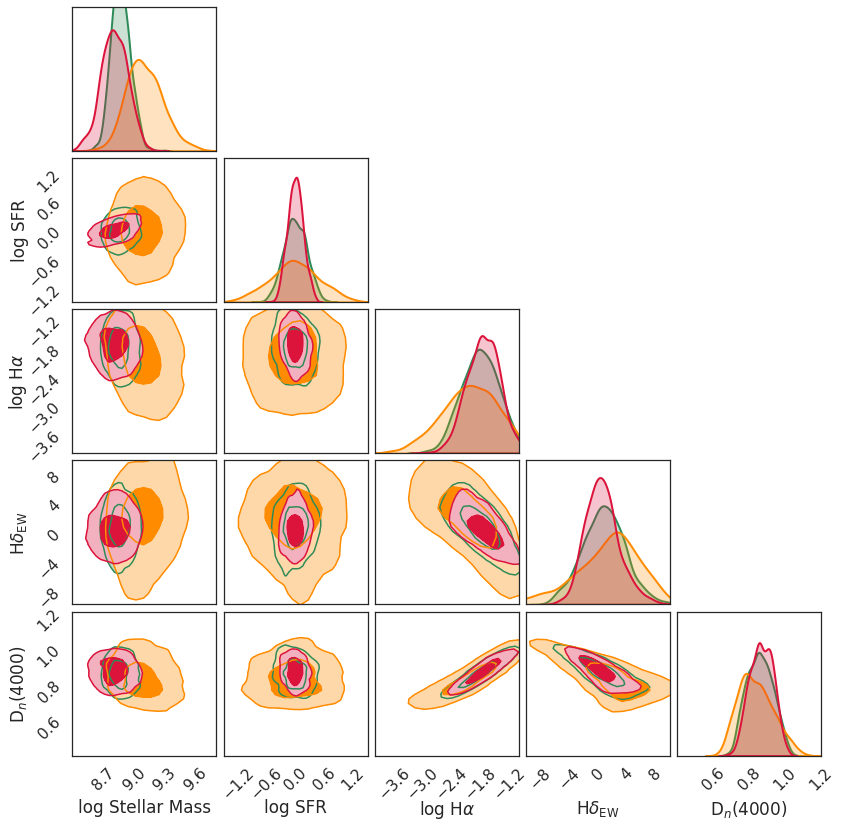

In [97]:
nsamp = 1000
tarr_res = 10000
zval = 0.1
random_seed = 42

cases = ['MW','dwarf','noon']
case_params = [kernel_params_MW_TCF20, kernel_params_dwarf_TCF20, kernel_params_noon_TCF20, kernel_params_highz_TCF20]
case_colors = ['crimson','darkorange','seagreen','deepskyblue']

plt.figure(figsize=(9,6))

smoothval = 1.0
nbins = 1000
binvals = [np.linspace(8.4,10.0,nbins), np.linspace(-3,3,nbins), np.linspace(-6,0,nbins), np.linspace(-10,10,nbins), np.linspace(0.4,1.4,nbins)]
lims = [(8.4,9.8),(-1.5,1.5),(-4,-1),(-10,10),(0.4,1.2)]

for i, case in reversed(list(enumerate(cases))):
    
    #fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    fname = 'precomputed_kernels/varsfh_'+case+'.h5'
    case1 = hickle.load(fname)

    case1.calc_spectral_features(massnorm = True)
    
    temphd = np.array(case1.hdelta_ews.copy())
    #temphd[temphd < -11] = -11
    
    tempha = np.array(np.log10(case1.ha_lums).copy())
    #tempha[tempha < -6] = -6
    
    case1_specfeatures = np.vstack((np.log10(case1.mstar), 
                                    (np.array(case1.samples)[0:,0]),
                                    tempha, temphd, case1.dn4000_vals))

    if i==2:
        fig = corner.corner(case1_specfeatures.T, 
                      labels=['log Stellar Mass', 'log SFR', r'log H$\alpha$', r'H$\delta_{\rm EW}$', 'D$_n$(4000)'],
                      levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], # quantiles=(0.16,0.84), 
                      plot_datapoints=False, fill_contours=True, smooth=smoothval,
                      color = case_colors[i], hist_kwargs={'lw':0, 'density':True})
        axes = np.array(fig.axes).reshape((5,5))
        all_specfeatures = case1_specfeatures
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        
    elif i<3:
        fig = corner.corner(case1_specfeatures.T, 
              levels=[1 - np.exp(-(1/1)**2/2),1 - np.exp(-(2/1)**2/2)], #quantiles=(0.16,0.84), 
              plot_datapoints=False, fill_contours=True, smooth=smoothval,
              color = case_colors[i], fig = fig, hist_kwargs={'lw':0, 'density':True})
        
        for kdei in range(5):
            axkde = axes[kdei, kdei]
            sns.kdeplot(case1_specfeatures[kdei,0:],shade=True,lw=2,color=case_colors[i],ax=axkde)
            axkde.set_ylabel('')
        all_specfeatures = np.hstack((all_specfeatures, case1_specfeatures))
        
# Extract the axes


#lims = [(10,14),(-3,3),(-6,0),(-10,10),(0.4,1.4)]



for i in range(5):
    ax = axes[i, i]
    ax.set_xlim(lims[i])
    
    for j in range(i):
        ax = axes[i,j]
        ax.set_xlim(lims[j])
        ax.set_ylim(lims[i])
#plt.savefig('figures/fig4_panel2_TCF20.png',bbox_inches='tight')
plt.show()

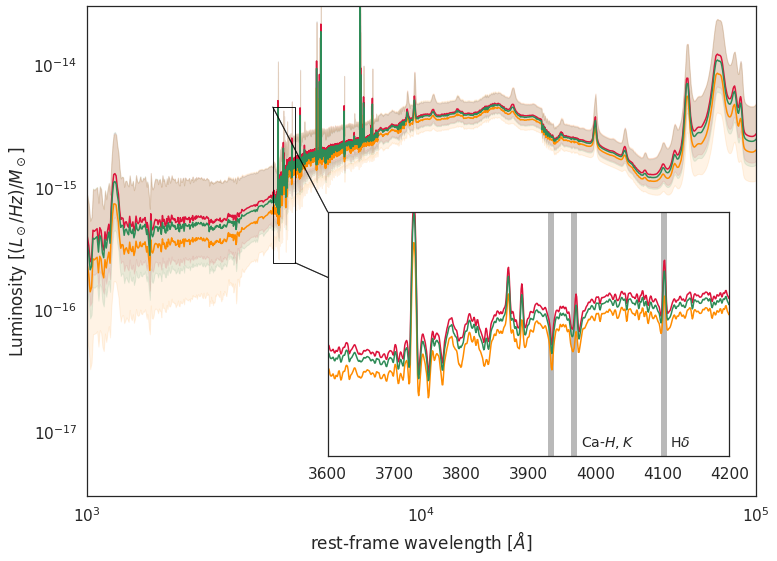

In [100]:

fig, axs = plt.subplots(figsize=(12,9))
axins = axs.inset_axes([0.36, 0.08, 0.6, 0.5])
axins.axvline(4101.734,color='k',alpha=0.3,lw=6)
axins.text(4101.734+10,9e-17*3.0,r'H$\delta$',fontsize=14)

axins.axvline(3968.47,color='k',alpha=0.3,lw=6)
axins.text(3968.47+10,9e-17*3.0,r'Ca-$H,K$',fontsize=14)
axins.axvline(3933.66,color='k',alpha=0.3,lw=6)
# axins.text(3933.66+10,9e-17,r'Ca-$K$',fontsize=14)

# plt.vlines(6562, 1e-18,1e-14,color='k',lw=5,alpha=0.3)
# plt.fill_between([4041,4161], [1e-18,1e-18],[1e-14,1e-14],color='k',alpha=0.3)
# plt.fill_between([3850,4100], [1e-18,1e-18],[1e-14,1e-14],color='k',alpha=0.3)

for i, case in enumerate(cases):
    
    fname = 'precomputed_kernels/varsfh_'+case+'.h5'
    #fname = 'precomputed_kernels/v2_ExReg_TCF20_'+case+'_constsfh_tarr%.0f_zval%.1f_nsamp%.0f_rseed%.0f.h5' %(tarr_res, zval, nsamp, random_seed)
    case1 = hickle.load(fname)
    
    lam_mask = (case1.lam[0] > 1e3) & (case1.lam[0] < 1e5)
    plt.plot(case1.lam[0][lam_mask], 
             np.nanmedian(np.array(case1.spec_massnorm),0)[lam_mask], color=case_colors[i])
    plt.fill_between(case1.lam[0][lam_mask], 
             np.nanpercentile(np.array(case1.spec_massnorm),16,0)[lam_mask], 
             np.nanpercentile(np.array(case1.spec_massnorm),84,0)[lam_mask], 
             color=case_colors[i],alpha=0.1)
    
    axins.plot(case1.lam[0][lam_mask], 
             np.nanmedian(np.array(case1.spec_massnorm),0)[lam_mask], color=case_colors[i])
    
    x1, x2, y1, y2 = 3600,4200, 8e-17*3.0,1.5e-15*3.0
    
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_yscale('log')
#     axins.set_xticklabels('')
    axins.set_yticklabels('')
    
    
    a,b = axs.indicate_inset_zoom(axins, edgecolor="black", )
    #print(b[0].get_visible(),b[1].get_visible())
    #b[0].set_visible = False
    #b[3].set_visible = False

    
    #axins.set_xscale('log')
    
plt.xscale('log');plt.yscale('log')
plt.xlabel('rest-frame wavelength [$\AA$]')
plt.ylabel('Luminosity [$(L_\odot/Hz)/M_\odot$]')
plt.xlim(1e3,1e5)
plt.ylim(1e-18*3.0,1e-14*3.0)
#plt.savefig('figures/fig4_panel1_TCF20.png',bbox_inches='tight')
plt.show()
